In [92]:
# The code was removed by Watson Studio for sharing.

This project will explore the best locations for chinese restuarants in New York City. 

In [93]:
import pandas as pd
import numpy as np
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import io
from io import BytesIO
#download dependencies

#!conda update -n base -c defaults conda
import json #library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library


Foursquare credentials

In [4]:
# The code was removed by Watson Studio for sharing.

Functions that will be used to gather the data from Foursquare API and construct dataframes.

In [94]:
# get geo location of address
def geo_location(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=600
    LIMIT=150
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    results = requests.get(url).json() # get all the data
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_nyc_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json() # all data is in features label
    
    features=resp['features'] # define the dataframe columns
    
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']  # instantiate the dataframe
    
    nyc_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        nyc_data = nyc_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return nyc_data

Get NYC geographic data.

In [95]:
nyc_data = get_nyc_data()
nyc_data.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [47]:
nyc_data.shape

(306, 4)

Review our initial data by creating a bar plot to look at the distribution of neigborhoods per borough.
We can see that Queens has the greatest number of neighborhoods and Manhattan has the least.

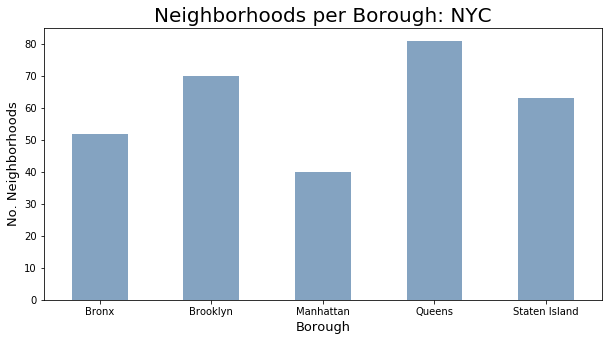

In [96]:
gry = 0.2, 0.4, 0.6, 0.6
nyc_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=gry)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 13)
plt.ylabel('No. Neighborhoods',fontsize = 13)
plt.xticks(rotation = 'horizontal')
plt.show()

Now we will look at how many Chinese restaurants there are in each of the boroughs and neighborhoods.

In [19]:
#Create a data frame that contains number of chinese restaurants per neighborhood using foursquare api call function get_venues.

column_names=['Borough', 'Neighborhood', 'ID','Name']
chi_res_nyc=pd.DataFrame(columns=column_names)
count=1
for row in nyc_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chi_res=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(nyc_data),')','Chinese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(chi_res)))
    print(row)
    for rest_detail in chi_res.values.tolist():
        id, name , category=rest_detail
        chi_res_nyc = chi_res_nyc.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1
  

( 1 / 306 ) Chinese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Chinese Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Chinese Restaurants in Eastchester, Bronx:1
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Chinese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Chinese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Chinese Restaurants in Kingsbridge, Bronx:1
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Chinese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Chinese Restaurants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Chinese Restaurants in Norwood, Bronx:1
['

In [58]:
chi_res_nyc.shape

(256, 4)

In [20]:
#save data to limit Foursquare calls
project.save_data("chinese restaurants nyc.csv", chi_res_nyc.to_csv(), overwrite=True)


{'file_name': 'chinese restaurants nyc.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'adscapstoneprojectasianbistroanal-donotdelete-pr-clrcdigez8xpsd',
 'asset_id': '04e0fac3-b7d9-47d0-91fd-8e9ebe4be434'}

In [30]:
chi_res_nyc = project.get_file("chinese restaurants nyc.csv")

chi_res_nyc = pd.read_csv(chi_res_nyc)
chi_res_nyc.head()
chi_res_nyc.drop(['Unnamed: 0'], axis=1, inplace = True)

In [31]:
chi_res_nyc.tail()

Borough Neighborhood                        ID  \
264  Brooklyn    Homecrest  4d28b924ebacb1f72efbf34f   
265  Brooklyn      Madison  4be32bd7b02ec9b61fc34ec0   
266     Bronx    Bronxdale  4c3f7f2eda3dc928b8f6c5b9   
267     Bronx     Allerton  4bc11181abf495219f7dc093   
268    Queens      Hammels  4c72ad2bad69b60cb31b84b9   

                             Name  
264  Wing Hing Seafood Restaurant  
265                      win hing  
266                Peking Kitchen  
267                  Li's Kitchen  
268         301 Chinese Resturant

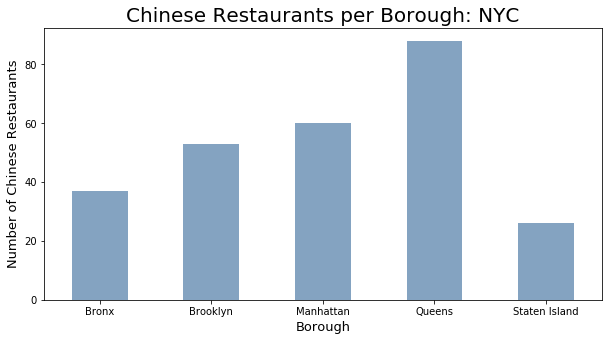

In [63]:
chi_res_nyc.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = gry )
plt.title('Chinese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 13)
plt.ylabel('Number of Chinese Restaurants', fontsize=13)
plt.xticks(rotation = 'horizontal')
plt.show()

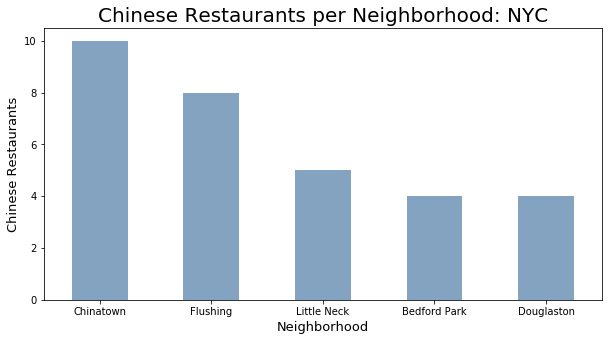

In [64]:
#Top 5 Neighborhoods with largest number of Chinese restaurants.
NofNeigh = 5
chi_res_nyc.groupby('Neighborhood')['ID'].count().nlargest(NofNeigh).plot.bar(figsize=(10,5), color=gry)
plt.title('Chinese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 13)
plt.ylabel('Chinese Restaurants', fontsize=13)
plt.xticks(rotation = 'horizontal')
plt.show()

Queens has the greatest number of Chinese restaurants per borough in NYC but the neighborhood of Chinatown in Manhattan has 
the highest number of Chinese restaurants in all of NYC.

In [65]:
chi_res_nyc[chi_res_nyc['Neighborhood']=='Chinatown']

Borough Neighborhood                        ID  \
73  Manhattan    Chinatown  4db3374590a0843f295fb69b   
74  Manhattan    Chinatown  5894c9a15e56b417cf79e553   
75  Manhattan    Chinatown  4a96bf8ff964a520ce2620e3   
76  Manhattan    Chinatown  3fd66200f964a520b1ea1ee3   
77  Manhattan    Chinatown  3fd66200f964a52067e61ee3   
78  Manhattan    Chinatown  46936ee3f964a520d0481fe3   
79  Manhattan    Chinatown  5c965dad5455b2002c058659   
80  Manhattan    Chinatown  3fd66200f964a520ede41ee3   
81  Manhattan    Chinatown  59ad625a2619ee5cdded881f   
82  Manhattan    Chinatown  3fd66200f964a520ceea1ee3   

                                 Name  
73                      Spicy Village  
74                 Xi'an Famous Foods  
75  Wah Fung Number 1 Fast Food 華豐快飯店  
76              Great N.Y. Noodletown  
77                 Joe's Shanghai 鹿嗚春  
78               Shanghai Café Deluxe  
79           Yi Ji Shi Mo Noodle Corp  
80                   Big Wong King 大旺  
81                 House Special 甘來飯店  
82         Deluxe Green Bo Restaurant

In [32]:
#make a call to Foursquare API to get Likes and Rating 

column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating']
chi_rest_stats_nyc=pd.DataFrame(columns=column_names)
count=1
for row in chi_res_nyc.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID) #assign 0 value for the restaurants as they may have been
                                            #recently opened or details do not exist in the FourSquare Database
        id,name,likes,rating=[0]*4                                                                                   
    print('(',count,'/',len(chi_res_nyc),')','processed')
    chi_rest_stats_nyc = chi_rest_stats_nyc.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                },ignore_index=True)
                                                                                             
                                        
                                               
    count+=1
chi_rest_stats_nyc.tail()

{'meta': {'code': 200, 'requestId': '5e21cb6071c428001bf35ef7'}, 'response': {'venue': {'id': '4dabc3dc93a04642f09ccabd', 'name': 'Xing Lung Chinese Restaurant', 'contact': {'phone': '7183241014', 'formattedPhone': '(718) 324-1014'}, 'location': {'address': '3828 B Dyre Ave', 'crossStreet': 'E 233 St', 'lat': 40.8887854684858, 'lng': -73.83122576835156, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8887854684858, 'lng': -73.83122576835156}], 'postalCode': '10466', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3828 B Dyre Ave (E 233 St)', 'Bronx, NY 10466', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xing-lung-chinese-restaurant/4dabc3dc93a04642f09ccabd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fals

Borough Neighborhood                        ID  \
264  Brooklyn    Homecrest  4d28b924ebacb1f72efbf34f   
265  Brooklyn      Madison                         0   
266     Bronx    Bronxdale  4c3f7f2eda3dc928b8f6c5b9   
267     Bronx     Allerton  4bc11181abf495219f7dc093   
268    Queens      Hammels  4c72ad2bad69b60cb31b84b9   

                             Name Likes Rating  
264  Wing Hing Seafood Restaurant    25    6.7  
265                             0     0      0  
266                Peking Kitchen     9    7.4  
267                  Li's Kitchen     2    7.1  
268         301 Chinese Resturant     9    6.3

In [33]:
chi_rest_stats_nyc.shape

(269, 6)

In [34]:
#save data to limit Foursquare calls
project.save_data("chinese restaurants stats nyc.csv", chi_rest_stats_nyc.to_csv(), overwrite=True)

{'file_name': 'chinese restaurants stats nyc.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'adscapstoneprojectasianbistroanal-donotdelete-pr-clrcdigez8xpsd',
 'asset_id': 'c6c329f9-c830-4f6a-8bd0-0cb1809997c2'}

In [97]:
chi_rest_stats_nyc = project.get_file("chinese restaurants stats nyc.csv")

chi_rest_stats_nyc = pd.read_csv(chi_rest_stats_nyc)
chi_rest_stats_nyc.drop(['Unnamed: 0'], axis=1, inplace = True)
chi_rest_stats_nyc.head()

Borough    Neighborhood                        ID  \
0   Bronx     Eastchester                         0   
1   Bronx     Kingsbridge                         0   
2   Bronx        Woodlawn                         0   
3   Bronx         Norwood                         0   
4   Bronx  Pelham Parkway  4b9d6b45f964a52078ab36e3   

                         Name  Likes  Rating  
0                           0      0     0.0  
1                           0      0     0.0  
2                           0      0     0.0  
3                           0      0     0.0  
4  Mr. Q's Chinese Restaurant      9     7.4

In [4]:
#drop rows with zero ratings
indexratingzero=chi_rest_stats_nyc[chi_rest_stats_nyc['Rating']==0].index
chi_rest_stats_nyc.drop(indexratingzero, inplace=True)
chi_rest_stats_nyc.tail()

Borough Neighborhood                        ID  \
263  Brooklyn    Homecrest  4b46743ff964a520892126e3   
264  Brooklyn    Homecrest  4d28b924ebacb1f72efbf34f   
266     Bronx    Bronxdale  4c3f7f2eda3dc928b8f6c5b9   
267     Bronx     Allerton  4bc11181abf495219f7dc093   
268    Queens      Hammels  4c72ad2bad69b60cb31b84b9   

                             Name  Likes  Rating  
263         Golden "Z" Restaurant      9     7.6  
264  Wing Hing Seafood Restaurant     25     6.7  
266                Peking Kitchen      9     7.4  
267                  Li's Kitchen      2     7.1  
268         301 Chinese Resturant      9     6.3

In [5]:
chi_rest_stats_nyc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 4 to 268
Data columns (total 6 columns):
Borough         162 non-null object
Neighborhood    162 non-null object
ID              162 non-null object
Name            162 non-null object
Likes           162 non-null int64
Rating          162 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 8.9+ KB


In [6]:
#look at the statistics of the table for likes, ratings
chi_rest_stats_nyc.describe()

Likes      Rating
count   162.000000  162.000000
mean    111.648148    7.512346
std     241.576820    0.943284
min       0.000000    5.400000
25%       6.000000    6.800000
50%      16.000000    7.600000
75%      70.000000    8.200000
max    1473.000000    9.200000

In [7]:
# Check restaurant with the max likes
chi_rest_stats_nyc.iloc[chi_rest_stats_nyc['Likes'].idxmax()]

Borough                           Queens
Neighborhood                 Little Neck
ID              53acac39498e3f6a67265048
Name                           Moonstone
Likes                                 32
Rating                               8.2
Name: 171, dtype: object

In [8]:
#chest restaurant with max ratings
chi_rest_stats_nyc.iloc[chi_rest_stats_nyc['Rating'].idxmax()]

Borough                           Queens
Neighborhood                 Little Neck
ID              53acac39498e3f6a67265048
Name                           Moonstone
Likes                                 32
Rating                               8.2
Name: 171, dtype: object

In [9]:
#create dataframe with average ratings per Neighborhood


neighborhood_stats = chi_rest_stats_nyc.groupby('Neighborhood', as_index=False).mean()[['Neighborhood','Rating']]
neighborhood_stats.columns=['Neighborhood','Average Rating']
neighborhood_stats.sort_values(['Average Rating'], ascending=False).head()


Neighborhood  Average Rating
33           Flatiron            9.20
15            Chelsea            9.20
88       West Village            8.95
60      Midtown South            8.90
42  Greenwich Village            8.90

In [10]:
#create dataframe with average ratings per borough
borough_stats=chi_rest_stats_nyc.groupby('Borough', as_index=False).mean()[['Borough','Rating']]
borough_stats.columns=['Borough', 'Average Rating']
borough_stats.sort_values(['Average Rating'], ascending=False).head()

Borough  Average Rating
2      Manhattan        8.062069
1       Brooklyn        7.436364
3         Queens        7.184615
4  Staten Island        6.922222
0          Bronx        6.810000

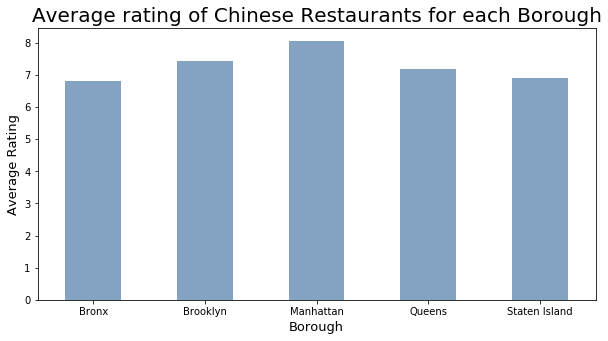

In [21]:
#plot the average rating per borough
borough_stats.groupby('Borough').mean()['Average Rating'].plot.bar(figsize=(10,5), color=gry)
plt.title('Average rating of Chinese Restaurants for each Borough', fontsize=20)
plt.xlabel('Borough',fontsize=13)
plt.ylabel('Average Rating', fontsize=13)
plt.xticks(rotation='horizontal')
plt.show()

We will map the neighborhoods with an average rating greater than or equal to 6 after joining the appropriate dataframes with geolocation data.

In [12]:
#create dataframe with average rating greater than 6
neighborhood_stats_rating = neighborhood_stats[neighborhood_stats['Average Rating']>=6.0]
neighborhood_stats_rating.shape

(88, 2)

In [17]:
#merge ratings df with lat and long
neighborhood_stats_rating = pd.merge(neighborhood_stats_rating, nyc_data, on='Neighborhood')
neighborhood_stats_rating=neighborhood_stats_rating[['Borough', 'Neighborhood','Latitude','Longitude','Average Rating']]
neighborhood_stats_rating.tail()

Borough     Neighborhood   Latitude  Longitude  Average Rating
86  Staten Island      Westerleigh  40.621090 -74.133041            7.25
87       Brooklyn     Williamsburg  40.707144 -73.958115            8.20
88       Brooklyn  Windsor Terrace  40.656946 -73.980073            8.90
89         Queens         Woodside  40.746349 -73.901842            8.30
90      Manhattan        Yorkville  40.775930 -73.947118            7.70

In [70]:
#geo_location isn't working below NYC coordinates from Google
latitude= 40.7128
longitude= -74.006

#create map with neighborhoods and rating
from folium import plugins

#start with clean copy of NYC map
nyc_map = folium.Map(location=[latitude, longitude], zoom_start=11)

#instantiate a marker cluster object for the ratings in the dataframe
chi_rating = plugins.MarkerCluster().add_to(nyc_map)

neighborhood_stats_rating['Label']= neighborhood_stats_rating['Neighborhood']+'('+neighborhood_stats_rating['Average Rating'].map(str)+')'
#loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in neighborhood_stats_rating[['Latitude','Longitude','Label']].values:
    folium.Marker(
        location=[lat,lng],
        icon=None,
        popup=label).add_to(chi_rating)
    
  
#display map
nyc_map
                                           
                                           


In [19]:
neighborhood_stats_rating.head()

Borough  Neighborhood   Latitude  Longitude  Average Rating  \
0     Bronx      Allerton  40.865788 -73.859319            7.10   
1    Queens       Astoria  40.768509 -73.915654            7.70   
2  Brooklyn    Bath Beach  40.599519 -73.998752            6.60   
3  Brooklyn     Bay Ridge  40.625801 -74.030621            7.35   
4     Bronx  Bedford Park  40.870185 -73.885512            6.45   

                             Label  
0                    Allerton(7.1)  
1                     Astoria(7.7)  
2    Bath Beach(6.599999999999999)  
3                  Bay Ridge(7.35)  
4  Bedford Park(6.449999999999999)

We will visualize the average rating for all Buroughs with a choropleth map.

In [87]:
# get nyc borough boundary json file

borough_bound = project.get_file('Borough Boundaries.geojson')
type(borough_bound)

_io.BytesIO

In [88]:
bor_b = pd.read_json(borough_bound)
bor_b.head()

type                                           features
0  FeatureCollection  {'type': 'Feature', 'properties': {'boro_code'...
1  FeatureCollection  {'type': 'Feature', 'properties': {'boro_code'...
2  FeatureCollection  {'type': 'Feature', 'properties': {'boro_code'...
3  FeatureCollection  {'type': 'Feature', 'properties': {'boro_code'...
4  FeatureCollection  {'type': 'Feature', 'properties': {'boro_code'...

In [91]:
json_bou=bor_b.to_json(orient='split')


In [77]:

nyc_geo = json_bou
nyc_map = folium.Map(location=[latitude,longitude], zoom_start=8)

nyc_map.choropleth(
    geo_data=nyc_geo,
    data=borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map

nyc_map